In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from library.sb_utils import save_file

In [2]:
#Define function to plot CDF plots

def cdf(x, plot=True,ylab='CDF', *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.plot(x, y, *args, **kwargs)  if plot else (x, y), plt.ylabel('CDF')
    
    

In [3]:
df= pd.read_csv('CC_fraud_cleaned.csv')
df.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Incorrect CVV Entered
0,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,2,1,rideshare,06/2023,2015-03-14,2015-03-14,1803,PURCHASE,0.0,0,0,0,0
1,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,9,1,entertainment,02/2024,2015-03-14,2015-03-14,767,PURCHASE,0.0,1,0,0,0
2,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,9,1,mobileapps,08/2025,2015-03-14,2015-03-14,767,PURCHASE,0.0,0,0,0,0
3,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,9,1,mobileapps,08/2025,2015-03-14,2015-03-14,767,PURCHASE,0.0,0,0,0,0
4,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,2,1,fastfood,10/2029,2015-08-06,2015-08-06,3143,PURCHASE,0.0,1,0,0,0


In [4]:
print(df.nunique())

customerId                    4997
creditLimit                     10
availableMoney              517244
transactionDateTime         767129
transactionAmount            65850
merchantName                  2489
acqCountry                       4
posEntryMode                     5
posConditionCode                 3
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1818
dateOfLastAddressChange       2182
cardLast4Digits               5241
transactionType                  3
currentBalance              483267
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
Incorrect CVV Entered            2
dtype: int64


## Look at merchantName and merchantCategoryCode 

In [5]:
df[['merchantName','merchantCategoryCode']]

,merchantName,merchantCategoryCode
0,Uber,rideshare
1,AMC #191138,entertainment
2,Play Store,mobileapps
3,Play Store,mobileapps
4,Tim Hortons #947751,fastfood
...,...,...
776608,Lyft,rideshare
776609,hulu.com,online_subscriptions
776610,Lyft,rideshare
776611,walmart.com,online_retail


In [6]:
'''since the 2,489 unique merchant names are already grouped by a merchant category code, it will be better to look at 
the 19 unique category codes instead.  Therefore, drop merchantName '''

df=df.drop(columns=['merchantName'])

In [7]:
#The card's last 4 digit and expiration date will also be of no use for our model, therefore drop it

df=df.drop(columns = ['cardLast4Digits','currentExpDate'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776613 entries, 0 to 776612
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customerId                776613 non-null  int64  
 1   creditLimit               776613 non-null  int64  
 2   availableMoney            776613 non-null  float64
 3   transactionDateTime       776613 non-null  object 
 4   transactionAmount         776613 non-null  float64
 5   acqCountry                776613 non-null  object 
 6   posEntryMode              776613 non-null  int64  
 7   posConditionCode          776613 non-null  int64  
 8   merchantCategoryCode      776613 non-null  object 
 9   accountOpenDate           776613 non-null  object 
 10  dateOfLastAddressChange   776613 non-null  object 
 11  transactionType           776613 non-null  object 
 12  currentBalance            776613 non-null  float64
 13  cardPresent               776613 non-null  i

In [9]:
#modify some data types

df[['customerId','posEntryMode','posConditionCode']]=df[['customerId','posEntryMode','posConditionCode']].astype('object')

df['transactionDateTime']=pd.to_datetime(df['transactionDateTime'])
df['accountOpenDate']=pd.to_datetime(df['accountOpenDate'])
df['dateOfLastAddressChange']=pd.to_datetime(df['dateOfLastAddressChange'])

#create a day column that tells what day was the transaction

df['Day']=df['transactionDateTime'].dt.day_name()

In [10]:
#create seperate data for fraud and normal activity


fraud = df[df['isFraud']==1]
normal = df[df['isFraud']==0]
print('Fraud: '+format(fraud.shape),'\nNormal: '+format(normal.shape))

Fraud: (11966, 18) 
Normal: (764647, 18)


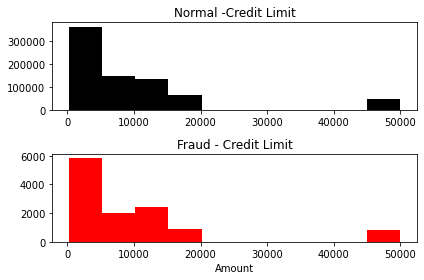

([<matplotlib.lines.Line2D at 0x1f9aa668400>], Text(0, 0.5, 'CDF'))

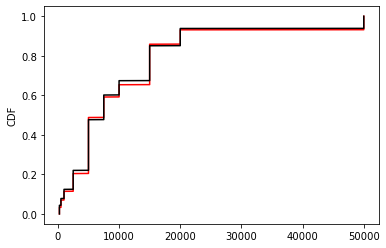

In [11]:
#Distribution for credit limit for normal and fraud activity seems normal

plt.subplot(2,1,1)
plt.title('Normal -Credit Limit')
plt.hist(normal['creditLimit'].values,color='k')

plt.subplot(2,1,2)
plt.hist(fraud['creditLimit'].values,color='r')

plt.title('Fraud - Credit Limit')
plt.xlabel('Amount')

plt.tight_layout()
plt.show()


cdf(fraud.creditLimit,color='r')
cdf(normal.creditLimit,color='k')

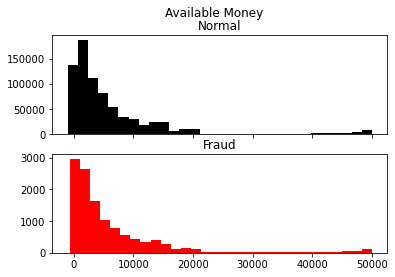

([<matplotlib.lines.Line2D at 0x1f9aa7b86a0>], Text(0, 0.5, 'CDF'))

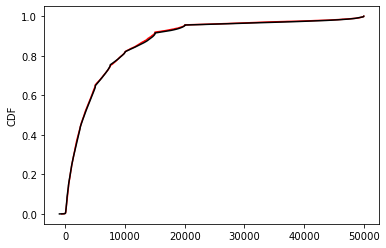

In [12]:
#Available money for both seems normal as well

f, (ax1,ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Available Money')


ax1.hist(normal.availableMoney,bins = 30,color='k')
ax1.set_title('Normal')
ax2.hist(fraud.availableMoney,bins=30,color='r')
ax2.set_title('Fraud')

plt.show()

cdf(fraud.availableMoney,color='r')
cdf(normal.availableMoney,color='k')

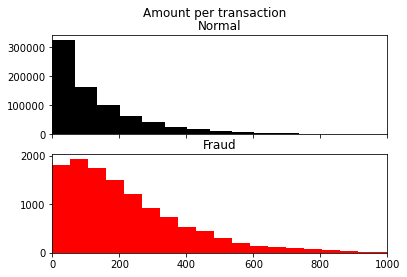

([<matplotlib.lines.Line2D at 0x1f9c40a3130>], Text(0, 0.5, 'CDF'))

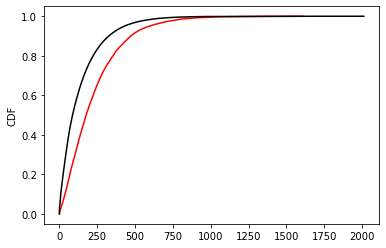

In [13]:
#fraud transactions occur at higher amounts, which makes sense. 

f, (ax1,ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction')
plt.xlim(0,1000)


ax1.hist(normal.transactionAmount,bins = 30,color='k')
ax1.set_title('Normal')

ax2.hist(fraud.transactionAmount,bins=30,color='r')
ax2.set_title('Fraud')



plt.show()


cdf(fraud.transactionAmount,color='r')
cdf(normal.transactionAmount,color='k')

US     769599
MEX      3089
CAN      2395
PR       1530
Name: acqCountry, dtype: int64
US     11826
MEX       63
CAN       51
PR        26
Name: acqCountry, dtype: int64


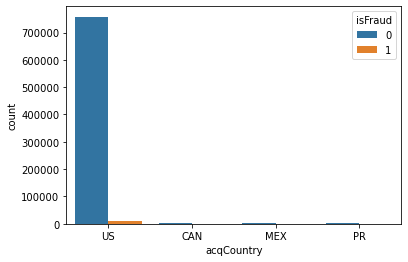

In [14]:
#Almost all transactions were made in US

sns.countplot(x='acqCountry',hue='isFraud',data=df)

print(df.acqCountry.value_counts())

print(fraud.acqCountry.value_counts())




In [15]:
df.posEntryMode.value_counts()

5     312689
9     234757
2     194543
90     19435
80     15189
Name: posEntryMode, dtype: int64

In [16]:
df.posConditionCode.value_counts()

1     621236
8     147961
99      7416
Name: posConditionCode, dtype: int64

In [17]:
fraud.merchantCategoryCode.value_counts()

online_retail    4761
online_gifts     1534
rideshare        1233
fastfood         1031
food              978
entertainment     930
airline           512
auto              264
hotels            241
subscriptions     209
furniture         102
health             88
personal care      83
Name: merchantCategoryCode, dtype: int64

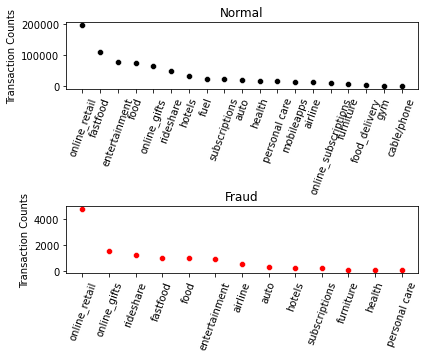

In [18]:
#online retail, online gifts and rideshare has the most occurances of fraud
#There are some merchant codes that don't have any fraud activity at all

plt.subplot(2,1,1)
sns.scatterplot(x=normal.merchantCategoryCode.value_counts().index,y=normal.merchantCategoryCode.value_counts(),color='k')
plt.xticks(rotation=70)
plt.title('Normal')
plt.ylabel('Transaction Counts')

plt.tight_layout()

plt.subplot(2,1,2)
sns.scatterplot(x=fraud.merchantCategoryCode.value_counts().index,y=fraud.merchantCategoryCode.value_counts(),color='r')
plt.xticks(rotation=70)
plt.title('Fraud')
plt.ylabel('Transaction Counts')

plt.show()

In [19]:
No_fraud = []

for i in df.merchantCategoryCode.unique():
    if i not in fraud.merchantCategoryCode.unique():
        No_fraud.append(i)

print('Merchant Codes where no fraud occured: '+format(No_fraud))


Merchant Codes where no fraud occured: ['mobileapps', 'food_delivery', 'gym', 'fuel', 'online_subscriptions', 'cable/phone']


In [20]:
#look at accountOpenDate, and dateOfLastAddressChange

df[['accountOpenDate','dateOfLastAddressChange']]


,accountOpenDate,dateOfLastAddressChange
0,2015-03-14,2015-03-14
1,2015-03-14,2015-03-14
2,2015-03-14,2015-03-14
3,2015-03-14,2015-03-14
4,2015-08-06,2015-08-06
...,...,...
776608,2012-08-23,2012-08-23
776609,2012-08-23,2012-08-23
776610,2012-08-23,2012-08-23
776611,2012-08-23,2012-08-23


It seems like fraudulent activity has a 3.4% higher rate of changing their address at least once

In [21]:
normal_changed_address = normal[normal.accountOpenDate!=normal.dateOfLastAddressChange]

normal_changed_address_ratio = len(normal_changed_address)/len(normal)

print('Rate of address changes in normal activity : '+format(round(normal_changed_address_ratio,3)))

Rate of address changes in normal activity : 0.525


In [22]:
fraud_changed_address = fraud[fraud.accountOpenDate!=fraud.dateOfLastAddressChange] 

fraud_changed_address_ratio = len(fraud_changed_address)/len(fraud)

print('Rate of address changes in fraud activity : '+format(round(fraud_changed_address_ratio,3)))

Rate of address changes in fraud activity : 0.559


In [23]:
#create a new column indictating if address was changed since opening the account
#1 for changed, 0 for unchanged

df['changedAddress'] = np.where(df.accountOpenDate!=df.dateOfLastAddressChange,1,0)


When looking at the time between transaction and account open date, the stats between fraudulent and nonfraudulent activities are very similar.  \


In [24]:
df2=df.copy()

In [25]:
df2['between'] = df2.transactionDateTime - df2.accountOpenDate

In [26]:
df2[df2['isFraud']==1].between.describe().to_frame().join(df2[df2['isFraud']==0].between.describe().to_frame(),lsuffix="_fraud", rsuffix="_normal")

,between_fraud,between_normal
count,11966,764647
mean,852 days 03:14:50.595102768,884 days 16:08:34.602840160
std,680 days 03:58:17.762166344,697 days 20:57:18.441589312
min,12 days 14:09:28,1 days 03:52:10
25%,426 days 19:09:55,430 days 07:45:46.500000
50%,666 days 13:13:09.500000,680 days 14:44:00
75%,1007 days 23:58:07.250000,1110 days 23:52:52
max,9890 days 04:09:32,9990 days 11:12:02


In [27]:
df2['between_change'] = df2.dateOfLastAddressChange - df2.accountOpenDate


In [28]:
#Not much more can be used for our model, so dropping these two columns

df = df.drop(columns = ['accountOpenDate','dateOfLastAddressChange'])

The ratio of address verification transaction types in fraudulent activities is significantly lower than for those in normal transactions.  Reversal in normal is about 2.7 times more than the rate in fraud

In [29]:
pd.DataFrame({'amount':normal.transactionType.value_counts(),'ratio':normal.transactionType.value_counts()/len(normal)})

,amount,ratio
PURCHASE,725059,0.948227
ADDRESS_VERIFICATION,19853,0.025964
REVERSAL,19735,0.025809


In [30]:
pd.DataFrame({'amount':fraud.transactionType.value_counts(),'ratio':fraud.transactionType.value_counts()/len(fraud)})

,amount,ratio
PURCHASE,11528,0.963396
REVERSAL,324,0.027077
ADDRESS_VERIFICATION,114,0.009527


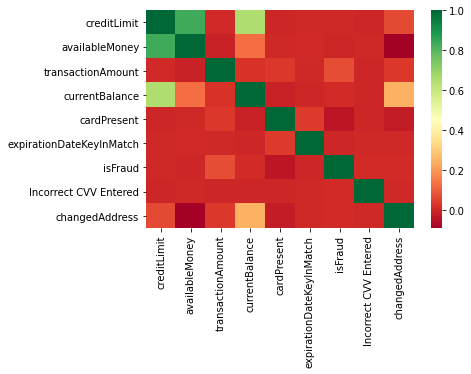

In [31]:
sns.heatmap(df.corr(),cmap='RdYlGn')

In [32]:
#look at transaction amount againts time

In [33]:
df_t = df.set_index('transactionDateTime').sort_index()

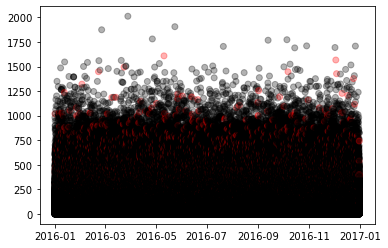

In [34]:
colors = {0:'black',1:'red'}

plt.scatter(df_t.index, df_t.transactionAmount, c=df_t.isFraud.map(colors),alpha=0.3)

Text(0.5, 0, 'Time')

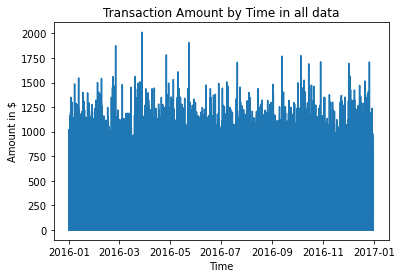

In [35]:


plt.plot(df_t.index,'transactionAmount',data=df_t)
plt.title('Transaction Amount by Time in all data')
plt.ylabel('Amount in $')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

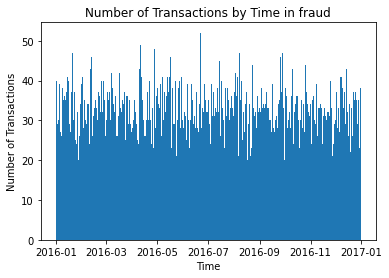

In [36]:

plt.hist(df_t[df_t['isFraud']==1].index,bins=365)
plt.title('Number of Transactions by Time in fraud')
plt.ylabel('Number of Transactions')
plt.xlabel('Time')



In [37]:
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['Day'] = pd.Categorical(df['Day'], categories=days, ordered=True)


df2=df.copy()
df2 = df2.sort_values('Day')

In [38]:
fraud2 = df2[df2['isFraud']==1]
normal2 = df2[df2['isFraud']==0]



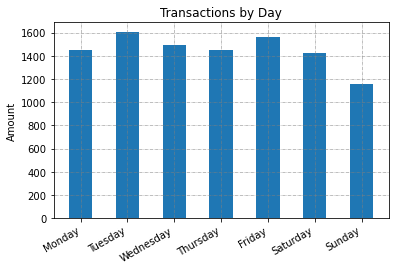

In [39]:
#Tuesday and Friday has the highest transaction amount with Sunday having the least

fig, ax = plt.subplots()
ax.bar(fraud2.Day,fraud2.transactionAmount,width=.5)    # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.title('Transactions by Day')
plt.ylabel('Amount')

  
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5) 


plt.show()

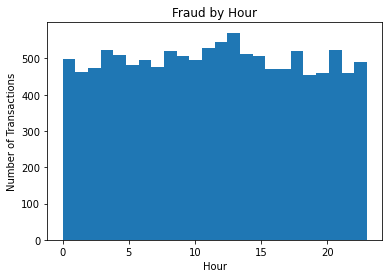

In [40]:
#Most fraud activities are happening around noon


plt.hist(fraud.transactionDateTime.dt.hour,bins=24)
plt.title('Fraud by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.show()



In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776613 entries, 0 to 776612
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customerId                776613 non-null  object        
 1   creditLimit               776613 non-null  int64         
 2   availableMoney            776613 non-null  float64       
 3   transactionDateTime       776613 non-null  datetime64[ns]
 4   transactionAmount         776613 non-null  float64       
 5   acqCountry                776613 non-null  object        
 6   posEntryMode              776613 non-null  object        
 7   posConditionCode          776613 non-null  object        
 8   merchantCategoryCode      776613 non-null  object        
 9   transactionType           776613 non-null  object        
 10  currentBalance            776613 non-null  float64       
 11  cardPresent               776613 non-null  int64         
 12  ex

In [42]:
df[['acqCountry' , 'posEntryMode' , 'posConditionCode' , 'merchantCategoryCode' , 'transactionType' , 'Day']].nunique()

acqCountry               4
posEntryMode             5
posConditionCode         3
merchantCategoryCode    19
transactionType          3
Day                      7
dtype: int64

The next step would be to get dummy variables for object and category columns ['acqCountry' , 'posEntryMode' , 'posConditionCode' , 'merchantCategoryCode' , 'transactionType' , 'Day']

Then normalize/scale ['availableMoney', 'transactionAmount'] 

I will also drop customerId

In [43]:
datapath = '../Springboard'
save_file(df, 'CC_fraud_EDA.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../Springboard\CC_fraud_EDA.csv"
